# Importing Libs and Data

In [1]:
import os
import PIL
import math
import random
import shutil
import tqdm

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearnex import patch_sklearn
patch_sklearn()

import sklearn
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import visualkeras

import keras
from keras import Sequential
from keras.layers import Dense, Rescaling, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.layers import RandomFlip, RandomContrast, RandomZoom, RandomRotation, Resizing
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier

print(tf.config.list_physical_devices())

seed = 42

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def create_or_fetch_data(fp, force_remake=False):
    name = fp[2:]
    if os.path.exists(f'{fp}/{name}.csv') and not force_remake:
        data = pd.read_csv(f'{fp}/{name}.csv')
    else:
        files = {'filename':[], 'label':[],'img':[]}
        with os.scandir(fp) as dir:
            for entry in dir:
                if entry.name == f'{name}.csv':
                    continue
                with os.scandir(f'{fp}/{entry.name}') as folder:
                    for img in folder:
                        # print(img.name)
                        files['filename'].append(img.name)
                        files['label'].append(entry.name)
                        files['img'].append(tf.keras.utils.img_to_array(tf.keras.utils.load_img(f"{fp}/{entry.name}/{img.name}", color_mode='grayscale')))

        data = pd.DataFrame(files)[files.keys()]
        data.to_csv(f'{fp}/{name}.csv', index=False)

    display(data)
    return data


train = create_or_fetch_data('./train', force_remake=True)
test = create_or_fetch_data('./test', force_remake=True)
validation = create_or_fetch_data('./validation', force_remake=True)

,filename,label,img
0,0026.jpg,Bean,"[[[184.0], [184.0], [185.0], [185.0], [185.0],..."
1,0028.jpg,Bean,"[[[87.0], [86.0], [83.0], [86.0], [95.0], [101..."
2,0029.jpg,Bean,"[[[216.0], [217.0], [219.0], [220.0], [220.0],..."
3,0030.jpg,Bean,"[[[173.0], [174.0], [175.0], [177.0], [178.0],..."
4,0034.jpg,Bean,"[[[172.0], [172.0], [172.0], [173.0], [173.0],..."
...,...,...,...
9023,0996.jpg,Tomato,"[[[182.0], [181.0], [181.0], [181.0], [181.0],..."
9024,0997.jpg,Tomato,"[[[33.0], [28.0], [23.0], [25.0], [31.0], [36...."
9025,0998.jpg,Tomato,"[[[135.0], [137.0], [138.0], [137.0], [135.0],..."
9026,0999.jpg,Tomato,"[[[143.0], [170.0], [155.0], [159.0], [155.0],..."


,filename,label,img
0,0001.jpg,Bean,"[[[61.0], [64.0], [67.0], [63.0], [44.0], [24...."
1,0002.jpg,Bean,"[[[93.0], [79.0], [54.0], [27.0], [15.0], [17...."
2,0003.jpg,Bean,"[[[134.0], [133.0], [132.0], [132.0], [133.0],..."
3,0004.jpg,Bean,"[[[156.0], [156.0], [156.0], [158.0], [161.0],..."
4,0005.jpg,Bean,"[[[132.0], [123.0], [104.0], [87.0], [83.0], [..."
...,...,...,...
2995,1196.jpg,Tomato,"[[[114.0], [113.0], [112.0], [112.0], [110.0],..."
2996,1197.jpg,Tomato,"[[[196.0], [210.0], [237.0], [215.0], [196.0],..."
2997,1198.jpg,Tomato,"[[[240.0], [220.0], [204.0], [214.0], [229.0],..."
2998,1199.jpg,Tomato,"[[[221.0], [230.0], [231.0], [221.0], [216.0],..."


,filename,label,img
0,0023.jpg,Bean,"[[[76.0], [66.0], [63.0], [71.0], [95.0], [96...."
1,0024.jpg,Bean,"[[[137.0], [140.0], [144.0], [145.0], [143.0],..."
2,0025.jpg,Bean,"[[[57.0], [58.0], [59.0], [60.0], [60.0], [60...."
3,0027.jpg,Bean,"[[[108.0], [102.0], [99.0], [96.0], [89.0], [8..."
4,0031.jpg,Bean,"[[[50.0], [48.0], [47.0], [46.0], [46.0], [45...."
...,...,...,...
2995,1396.jpg,Tomato,"[[[129.0], [133.0], [124.0], [117.0], [122.0],..."
2996,1397.jpg,Tomato,"[[[116.0], [107.0], [100.0], [101.0], [106.0],..."
2997,1398.jpg,Tomato,"[[[235.0], [237.0], [237.0], [235.0], [234.0],..."
2998,1399.jpg,Tomato,"[[[202.0], [200.0], [198.0], [197.0], [196.0],..."


In [3]:
vegtables = np.unique(train.label)
veg_count = {'veg':[],'train':[],'test':[],'validation':[]}
for veg in vegtables:
    veg_count['veg'].append(veg)
    veg_count['train'].append(len(train[train.label==veg]))
    veg_count['test'].append(len(test[test.label==veg]))
    veg_count['validation'].append(len(validation[validation.label==veg]))
    
veg_count = pd.DataFrame(veg_count)
veg_count

,veg,train,test,validation
0,Bean,780,200,200
1,Bitter_Gourd,720,200,200
2,Bottle_Gourd,441,200,200
3,Brinjal,868,200,200
4,Broccoli,750,200,200
5,Cabbage,503,200,200
6,Capsicum,351,200,200
7,Carrot,256,200,200
8,Cauliflower,587,200,200
9,Cucumber,812,200,200


In [4]:
classes = veg_count.veg
classes

0             Bean
1     Bitter_Gourd
2     Bottle_Gourd
3          Brinjal
4         Broccoli
5          Cabbage
6         Capsicum
7           Carrot
8      Cauliflower
9         Cucumber
10          Papaya
11          Potato
12         Pumpkin
13          Radish
14          Tomato
Name: veg, dtype: object

In [5]:
veg_count[['veg','train']].set_index('veg').T

veg,Bean,Bitter_Gourd,Bottle_Gourd,Brinjal,Broccoli,Cabbage,Capsicum,Carrot,Cauliflower,Cucumber,Papaya,Potato,Pumpkin,Radish,Tomato
train,780,720,441,868,750,503,351,256,587,812,566,377,814,248,955


C:\Users\linco\AppData\Local\Temp\ipykernel_24948\3473044687.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=temp.columns, x=temp.iloc[0], palette='pastel')


<Axes: xlabel='train', ylabel='veg'>

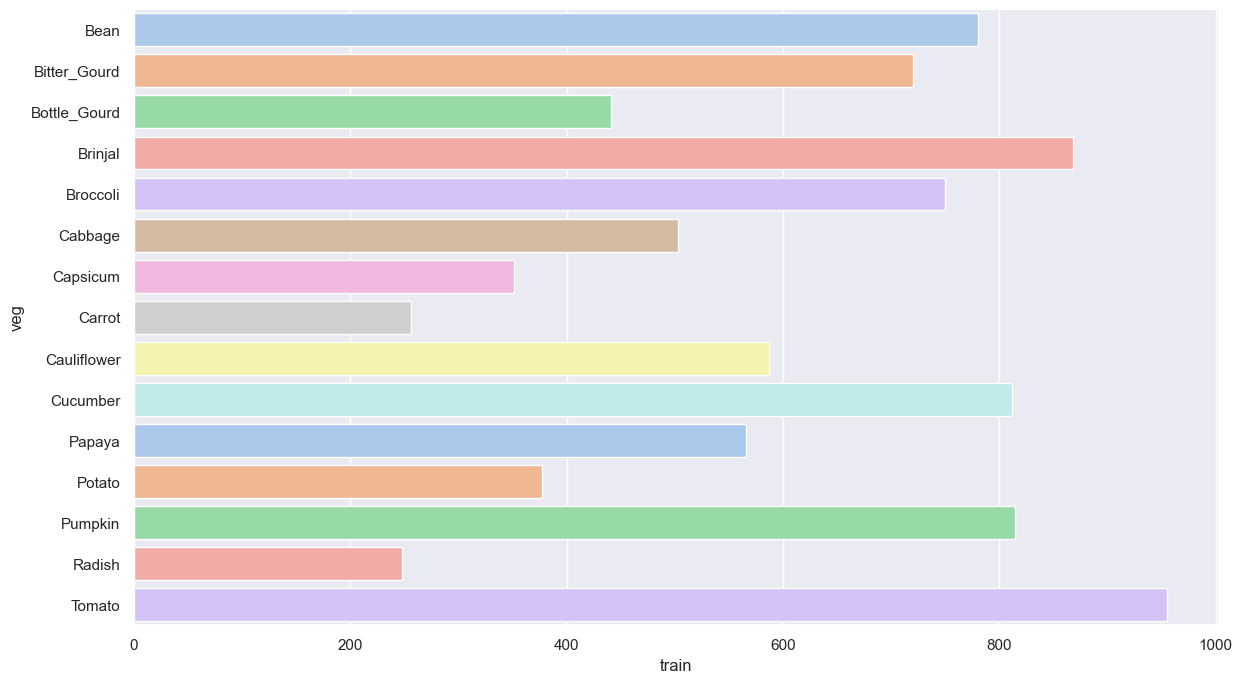

In [6]:
temp = veg_count[['veg','train']].set_index('veg').T
fig = plt.figure(figsize=(14,8))
sns.barplot(y=temp.columns, x=temp.iloc[0], palette='pastel')

In [7]:
veg_count.describe()

,train,test,validation
count,15.000000,15.0,15.0
mean,601.866667,200.0,200.0
std,231.118667,0.0,0.0
min,248.000000,200.0,200.0
25%,409.000000,200.0,200.0
50%,587.000000,200.0,200.0
75%,796.000000,200.0,200.0
max,955.000000,200.0,200.0


# Functions

In [8]:
def make_dataset(fp, img_size, batch_size):
    return tf.keras.utils.image_dataset_from_directory(
    directory=fp,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    image_size=(img_size, img_size))

In [9]:
def create_aug_dataset(class_size, dataset, fp, img_size):
    data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.3),
    RandomZoom(0.2)
    ])

    resize = Resizing(img_size,img_size)

    if not os.path.exists(fp):
        os.mkdir(fp)

    if not os.path.exists(f'{fp}/{class_size}'):
        os.mkdir(f'{fp}/{class_size}')
        
        for veg in tqdm.tqdm(vegtables, desc='Checking & Creating Individual Folders'):
            path = f'{fp}/{class_size}/{veg}'
            if not os.path.exists(path):
                os.mkdir(path)
            elif len([1 for x in os.scandir(path)]) != class_size:
                shutil.rmtree(path, ignore_errors=True)
                os.mkdir(path)
                    
        for veg in tqdm.tqdm(vegtables, desc='Augmenting & Populating Folders'):
            # print(veg)

            current = dataset[dataset.label==veg][['label','img']]
            img_tensor = tf.convert_to_tensor(np.stack(list(map(resize,current.img))))
            additional = tf.identity(img_tensor)
            if len(current) < class_size:
                diff = class_size - len(current)
                n = math.ceil(diff/len(current))
            else:
                n=1

            for i in range(n):
                aug_data = data_augmentation(img_tensor).numpy()
                additional =np.concatenate((additional, aug_data))

            np.random.shuffle(additional)
            for i in range(class_size):
                data = PIL.Image.fromarray(additional[i].squeeze()).convert('L')
                data.save(f'{fp}/{class_size}/{veg}/{i+1:04}-aug-{img_size}.jpg')
    
    else:
        print('Dataset found in device.')

    

In [10]:
def get_results(model, test_ds, best_fp,last_fp=None, checkpoint=None, ):
    results = pd.DataFrame({
        'loss': [],
        'acc': [],
        'precision': [],
        'recall': [],
        'auc': [],
    })

    best_model = model()
    best_model.load_weights(best_fp)
    best_loss, best_acc, best_precision, best_recall, best_auc  = best_model.evaluate(test_ds, verbose=1)
    results = pd.concat((results, pd.DataFrame([[best_loss, best_acc, best_precision, best_recall, best_auc]], columns=results.columns, index=[checkpoint if checkpoint is not None else 'best' ])), axis=0)

    if last_fp is not None:
        last_model = model()
        last_model.load_weights(last_fp)
        last_loss, last_acc, last_precision, last_recall, last_auc = last_model.evaluate(test_ds, verbose=1)
        results = pd.concat((results, pd.DataFrame([[last_loss, last_acc, last_precision, last_recall, last_auc]], columns=results.columns, index=['last'])), axis=0)

    return results

# Models

In [11]:
def get_model(conv_nodes, dense_nodes, kernel, stride, img_size, activation, dropout, lr, summary=True):
    model = Sequential([
        Conv2D(conv_nodes, kernel, stride, input_shape=(img_size,img_size, 1), padding='same', activation=activation),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes, kernel, stride, padding='same', activation=activation),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes, kernel, stride, padding='same', activation=activation),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Flatten(),
        Dense(dense_nodes, activation=activation),
        Dropout(rate=dropout),
        Dense(len(classes))
    ])

    optimizer = Adam(learning_rate=lr)
    loss = CategoricalCrossentropy(from_logits=True)
    metrics = ['accuracy',Precision(), Recall(), AUC()]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    if summary:
        model.summary()

    return model

In [12]:
def get_modelv2(conv_nodes, dense_nodes, kernel, stride, img_size, activation, dropout, lr, summary=True):
    model = Sequential([
        Conv2D(conv_nodes*0.25, kernel, stride, input_shape=(img_size,img_size, 1), padding='same', activation=activation),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes*0.5, kernel, stride, padding='same', activation=activation),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes, kernel, stride, padding='same', activation=activation),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Flatten(),
        Dense(dense_nodes, activation=activation),
        BatchNormalization(),
        Dropout(rate=dropout),
        Dense(len(classes))
    ])

    optimizer = Adam(learning_rate=lr)
    loss = CategoricalCrossentropy(from_logits=True)
    metrics = ['accuracy',Precision(), Recall(), AUC()]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    if summary:
        model.summary()

    return model

In [13]:
def get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, activation, dropout, lr, summary=True):
    model = Sequential([
        Conv2D(conv_nodes*0.25, kernel, stride, input_shape=(img_size,img_size, 1), padding='same', activation=activation),
        BatchNormalization(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes*0.5, kernel, stride, padding='same', activation=activation),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes, kernel, stride, padding='same', activation=activation),
        BatchNormalization(),
        Dropout(rate=dropout),
        Conv2D(conv_nodes, kernel, stride, padding='same', activation=activation),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(rate=dropout),
        Flatten(),
        Dense(dense_nodes, activation=activation),
        BatchNormalization(),
        Dropout(rate=dropout),
        Dense(len(classes))
    ])

    optimizer = Adam(learning_rate=lr)
    loss = CategoricalCrossentropy(from_logits=True)
    metrics = ['accuracy',Precision(), Recall(), AUC()]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    if summary:
        model.summary()

    return model

# Img_size 31

## Dataset

### Dataset Hyperparameter

In [79]:
#Hyper Parameters for Dataset
img_size= 31
batch_size = 32
class_size = 1000


In [18]:
train31_ds = make_dataset('train/', img_size, batch_size)
test31_ds = make_dataset('test/', img_size, batch_size)
validation31_ds = make_dataset('validation/', img_size, batch_size)

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## Data Augmentation

### Augmenting dataset to equal class size

In [19]:
create_aug_dataset(class_size, train, f'./train-aug-{31}', img_size)
# create_aug_dataset(class_size, test, f'./test-aug-{31}',  img_size)

Dataset found in device.


In [20]:
train_aug31_ds = make_dataset(f'train-aug-31/{class_size}/', img_size, batch_size)

Found 15000 files belonging to 15 classes.


## Model Training

In [80]:
#Hyper parameters for model
conv_nodes = 256
dense_nodes = 256

lr = 1e-3
dropout = 0.3
kernel = 3
stride = 1
epochs = 100

model_format = f'{conv_nodes}-{dense_nodes}-{dropout}-{batch_size}-{epochs}'

In [81]:
if not os.path.exists(f'./model_checkpoints/{class_size}'):
    os.mkdir(f'./model_checkpoints/{class_size}')
if not os.path.exists(f'./model_checkpoints/{class_size}/img{img_size}'):
    os.mkdir(f'./model_checkpoints/{class_size}/img{img_size}')

In [82]:
#Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reducelr = ReduceLROnPlateau(monitor='val_loss',patience=10)

In [86]:
asdf = get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    
visualkeras.layered_view(asdf).show()

Model: "sequential_151"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_481 (Conv2D)         (None, 31, 31, 64)        640       
                                                                 
 batch_normalization_321 (Ba  (None, 31, 31, 64)       256       
 tchNormalization)                                               
                                                                 
 dropout_629 (Dropout)       (None, 31, 31, 64)        0         
                                                                 
 conv2d_482 (Conv2D)         (None, 31, 31, 128)       73856     
                                                                 
 batch_normalization_322 (Ba  (None, 31, 31, 128)      512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_407 (MaxPooli  (None, 15, 15, 128)   

### Model31


In [25]:
with tf.device('/GPU:0'):   
    model31_noaug = get_model(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    
    visualkeras.layered_view(model31_noaug).show()
    model31_noaug_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}noaug_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history31_noaug = model31_noaug.fit(train31_ds ,validation_data=validation31_ds, epochs=epochs, shuffle=True, callbacks=[model31_noaug_checkpoint,reducelr])
    model31_noaug.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}noaug_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 31, 31, 256)       2560      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 15, 15, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 15, 256)       590080    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 256)        

In [26]:
history31_noaug_df = pd.DataFrame(history31_noaug.history)
history31_noaug_df

,loss,accuracy,precision_1,recall_1,auc_1,val_loss,val_accuracy,val_precision_1,val_recall_1,val_auc_1,lr
0,3.308577,0.173903,0.127609,0.507975,0.676969,2.288930,0.254667,0.138087,0.642333,0.731348,1.000000e-03
1,2.005797,0.346921,0.143566,0.795082,0.776411,1.957978,0.368667,0.155251,0.790333,0.789857,1.000000e-03
2,1.731335,0.440297,0.145734,0.875388,0.798336,1.562919,0.485333,0.159377,0.890333,0.831048,1.000000e-03
3,1.480219,0.519384,0.149081,0.922574,0.812743,1.379180,0.573000,0.164631,0.916667,0.843233,1.000000e-03
4,1.306559,0.580749,0.147621,0.946832,0.815682,1.096012,0.661333,0.150470,0.965667,0.831934,1.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...
95,0.060929,0.978954,0.160266,0.999889,0.822215,0.498282,0.902667,0.161386,0.993333,0.824125,1.000000e-08
96,0.059527,0.980727,0.159773,1.000000,0.821670,0.498282,0.902667,0.161386,0.993333,0.824125,1.000000e-09
97,0.062468,0.979841,0.159923,1.000000,0.821709,0.498281,0.902667,0.161386,0.993333,0.824125,1.000000e-09
98,0.065136,0.981170,0.159965,0.999889,0.821802,0.498281,0.902667,0.161386,0.993333,0.824125,1.000000e-09


In [27]:
with tf.device('/GPU:0'):   
    model31 = get_model(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    
    visualkeras.layered_view(model31).show()
    model31_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history31 = model31.fit(train_aug31_ds ,validation_data=validation31_ds, epochs=epochs, shuffle=True, callbacks=[model31_checkpoint,reducelr])
    model31.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 31, 31, 256)       2560      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 15, 15, 256)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 15, 15, 256)       590080    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 256)        

In [28]:
history31_df = pd.DataFrame(history31.history)
history31_df


,loss,accuracy,precision_2,recall_2,auc_2,val_loss,val_accuracy,val_precision_2,val_recall_2,val_auc_2,lr
0,2.986405,0.190133,0.129906,0.495200,0.679957,2.088364,0.333000,0.193043,0.636333,0.795667,1.000000e-03
1,1.873996,0.388467,0.158887,0.801000,0.795476,1.574384,0.508333,0.175507,0.850333,0.827660,1.000000e-03
2,1.515133,0.509400,0.163993,0.892000,0.822703,1.268263,0.625000,0.174382,0.916667,0.846098,1.000000e-03
3,1.242018,0.599133,0.162431,0.938200,0.832768,1.027650,0.692333,0.177870,0.944667,0.857042,1.000000e-03
4,0.997737,0.675933,0.164979,0.964333,0.838551,0.926538,0.714667,0.170180,0.966000,0.847723,1.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...
95,0.055308,0.982800,0.178545,0.999933,0.844622,0.633210,0.897667,0.179870,0.987667,0.844431,1.000000e-10
96,0.056855,0.981067,0.177703,0.999733,0.843811,0.633210,0.897667,0.179870,0.987667,0.844431,1.000000e-10
97,0.061543,0.980667,0.178266,1.000000,0.844307,0.633210,0.897667,0.179870,0.987667,0.844431,1.000000e-10
98,0.061506,0.981200,0.178705,0.999667,0.844964,0.633210,0.897667,0.179870,0.987667,0.844431,1.000000e-10


#### Effects of data augmentation on base model

In [34]:
model31.evaluate(test31_ds)

94/94 [==============================] - 1s 9ms/step - loss: 0.4980 - accuracy: 0.8993 - precision_2: 0.1815 - recall_2: 0.9903 - auc_2: 0.8475


[0.4979962706565857,
 0.8993333578109741,
 0.18152379989624023,
 0.9903333187103271,
 0.8474944829940796]

In [35]:
model31_noaug.evaluate(test31_ds)

94/94 [==============================] - 1s 8ms/step - loss: 0.3753 - accuracy: 0.9133 - precision_1: 0.1616 - recall_1: 0.9947 - auc_1: 0.8256


[0.37534189224243164,
 0.9133333563804626,
 0.16162928938865662,
 0.9946666955947876,
 0.8256374597549438]

In [29]:
def show_plots(df, ignore=0):
    feats = (len(df.columns)-1)//2
    for i in range(feats):
        df.iloc[ignore:,[i,i+feats]].plot()

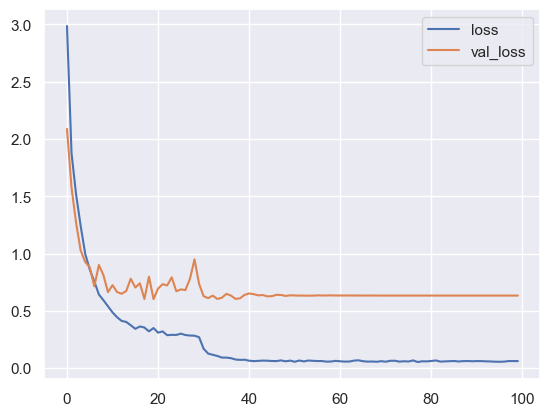

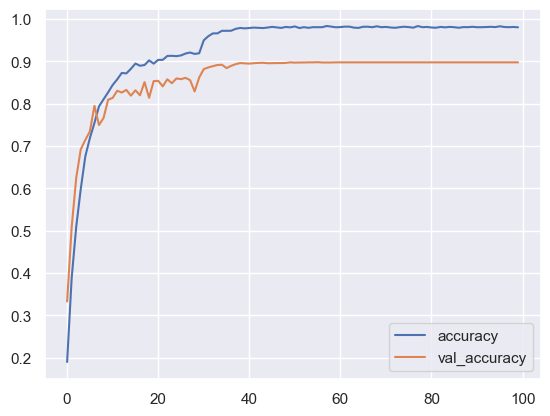

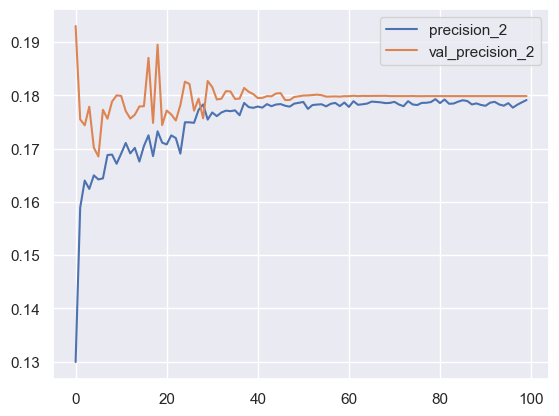

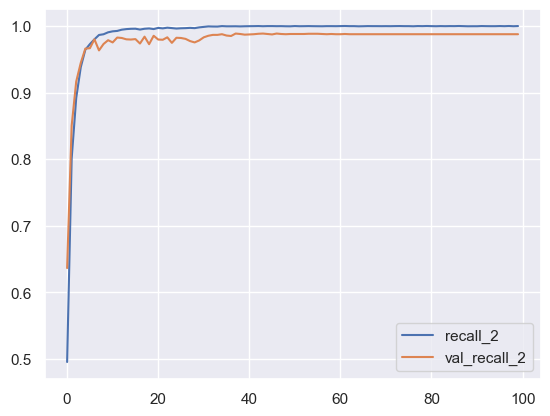

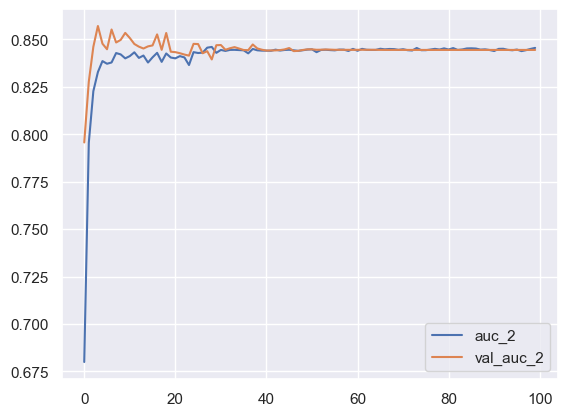

In [31]:
show_plots(history31_df)

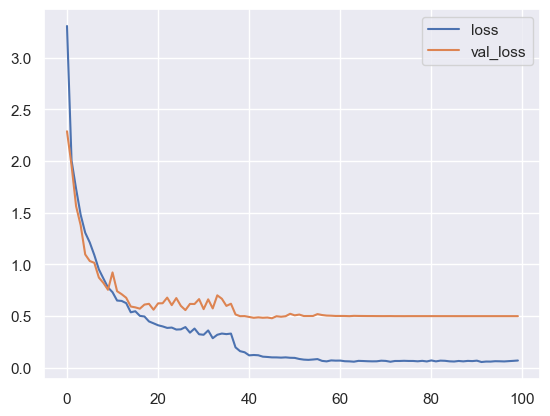

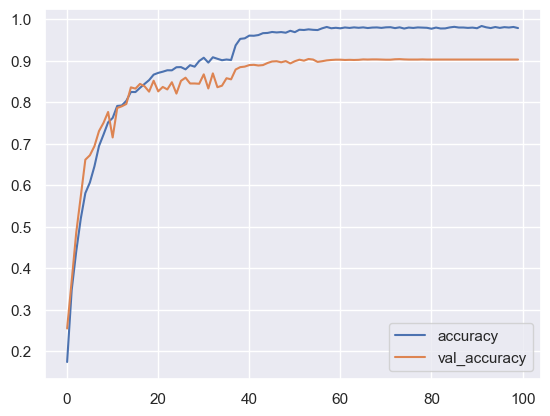

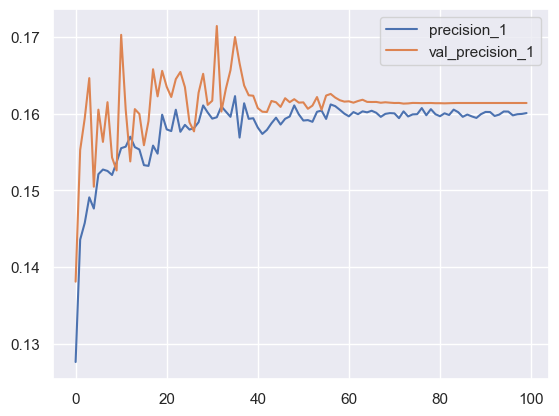

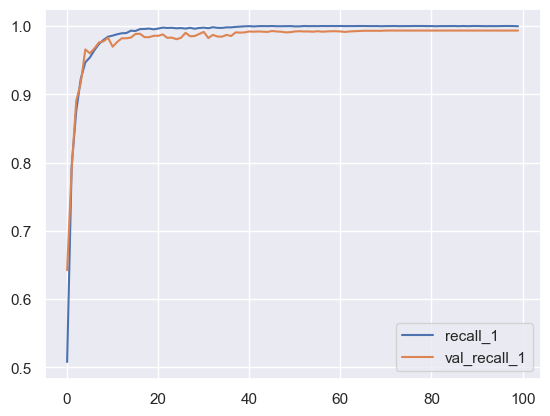

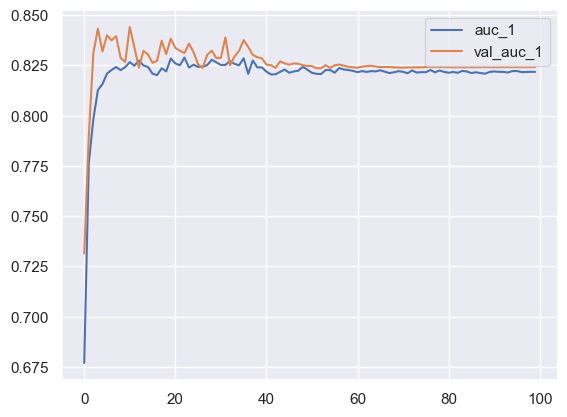

In [32]:
show_plots(history31_noaug_df)

### Model31V2

In [65]:
with tf.device('/GPU:0'):   
    model31v2 = get_modelv2(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    visualkeras.layered_view(model31v2).show()
    model31v2_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history31v2 = model31v2.fit(train_aug31_ds ,validation_data=validation31_ds, epochs=epochs, shuffle=True, callbacks=[model31v2_checkpoint,reducelr])
    model31v2.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 31, 31, 64)        640       
                                                                 
 batch_normalization_73 (Bat  (None, 31, 31, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 dropout_73 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_59 (Conv2D)          (None, 15, 15, 128)       73856     
                                                                 
 batch_normalization_74 (Bat  (None, 15, 15, 128)    

In [66]:
history31v2_df = pd.DataFrame(history31v2.history)
history31v2_df


,loss,accuracy,precision_16,recall_16,auc_16,val_loss,val_accuracy,val_precision_16,val_recall_16,val_auc_16,lr
0,1.431440,0.561667,0.157766,0.912267,0.820753,0.781607,0.760000,0.166431,0.979667,0.853498,1.000000e-03
1,0.641189,0.801067,0.166302,0.986867,0.852052,0.535152,0.835000,0.171344,0.987000,0.858336,1.000000e-03
2,0.388296,0.878000,0.168913,0.996933,0.855114,0.645034,0.799667,0.173191,0.986667,0.856249,1.000000e-03
3,0.261806,0.919733,0.169155,0.998467,0.853225,0.412094,0.874667,0.172725,0.994667,0.856318,1.000000e-03
4,0.198518,0.937667,0.167639,0.999533,0.850506,1.311318,0.654333,0.144324,0.960667,0.802328,1.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...
95,0.004909,0.998933,0.169706,1.000000,0.844212,0.208266,0.953000,0.172493,0.998333,0.847889,1.000000e-10
96,0.004548,0.998733,0.169779,1.000000,0.844212,0.207818,0.953000,0.172384,0.998333,0.848055,1.000000e-11
97,0.004619,0.998867,0.169270,1.000000,0.843617,0.208357,0.953333,0.172364,0.998333,0.848425,1.000000e-11
98,0.004879,0.998267,0.168980,1.000000,0.843371,0.208405,0.953000,0.172503,0.998333,0.848162,1.000000e-11


#### no data aug

In [55]:
with tf.device('/GPU:0'):   
    model31v2_noaug = get_modelv2(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    visualkeras.layered_view(model31v2_noaug).show()
    model31v2_noaug_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2noaug_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history31v2_noaug = model31v2_noaug.fit(train31_ds ,validation_data=validation31_ds, epochs=epochs, shuffle=True, callbacks=[model31v2_noaug_checkpoint,reducelr])
    model31v2_noaug.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2noaug_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_331 (Conv2D)         (None, 31, 31, 64)        640       
                                                                 
 batch_normalization_190 (Ba  (None, 31, 31, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_287 (MaxPooli  (None, 15, 15, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_434 (Dropout)       (None, 15, 15, 64)        0         
                                                                 
 conv2d_332 (Conv2D)         (None, 15, 15, 128)       73856     
                                                                 
 batch_normalization_191 (Ba  (None, 15, 15, 128)   

In [56]:
history31v2_noaug_df = pd.DataFrame(history31v2_noaug.history)
history31v2_noaug_df

,loss,accuracy,precision_103,recall_103,auc_103,val_loss,val_accuracy,val_precision_103,val_recall_103,val_auc_103,lr
0,1.961868,0.416925,0.144813,0.822663,0.772233,1.429200,0.546333,0.176899,0.922000,0.844162,1.000000e-03
1,1.206111,0.617191,0.162507,0.946167,0.836996,1.463031,0.563333,0.150423,0.919333,0.805509,1.000000e-03
2,0.881833,0.721090,0.165348,0.976517,0.847938,1.081374,0.675667,0.158281,0.957333,0.829197,1.000000e-03
3,0.691543,0.779353,0.165194,0.987705,0.849849,0.645609,0.797667,0.169301,0.985333,0.853253,1.000000e-03
4,0.598946,0.805605,0.163733,0.992357,0.847555,0.751544,0.770667,0.160803,0.979667,0.837063,1.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...
95,0.024858,0.992911,0.168527,1.000000,0.844357,0.169941,0.958000,0.175595,0.998667,0.853730,1.000000e-08
96,0.026385,0.992357,0.168688,1.000000,0.844492,0.169817,0.958333,0.175860,0.999000,0.853827,1.000000e-08
97,0.023163,0.994129,0.168839,1.000000,0.844432,0.169351,0.958000,0.176194,0.998667,0.854035,1.000000e-08
98,0.023220,0.993243,0.168811,1.000000,0.844429,0.169534,0.958333,0.175739,0.998667,0.853491,1.000000e-08


In [ ]:
model31v2.evaluate(test31_ds)

In [58]:
model31v2_noaug.evaluate(test31_ds)

94/94 [==============================] - 1s 11ms/step - loss: 0.1358 - accuracy: 0.9617 - precision_103: 0.1771 - recall_103: 0.9997 - auc_103: 0.8542


[0.13582128286361694,
 0.9616666436195374,
 0.17707841098308563,
 0.999666690826416,
 0.8541779518127441]

### Model31_CC

In [67]:
with tf.device('/GPU:0'):   
    model31_cc = get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    visualkeras.layered_view(model31_cc).show()
    model31_cc_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history31_cc = model31_cc.fit(train_aug31_ds ,validation_data=validation31_ds, epochs=epochs, shuffle=True, callbacks=[model31_cc_checkpoint,reducelr])
    model31_cc.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 31, 31, 64)        640       
                                                                 
 batch_normalization_77 (Bat  (None, 31, 31, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_77 (Dropout)        (None, 31, 31, 64)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 31, 31, 128)       73856     
                                                                 
 batch_normalization_78 (Bat  (None, 31, 31, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 15, 15, 128)    

In [68]:
history31_cc_df = pd.DataFrame(history31_cc.history)
history31_cc_df

,loss,accuracy,precision_17,recall_17,auc_17,val_loss,val_accuracy,val_precision_17,val_recall_17,val_auc_17,lr
0,1.191552,0.635400,0.163671,0.928667,0.834505,1.497736,0.628667,0.146497,0.950667,0.807385,1.000000e-03
1,0.479080,0.855200,0.168870,0.992267,0.855705,0.607626,0.812333,0.169245,0.984667,0.851050,1.000000e-03
2,0.251295,0.924733,0.168467,0.998200,0.853476,0.373412,0.890000,0.166034,0.991000,0.846463,1.000000e-03
3,0.127558,0.961600,0.168030,0.999400,0.851588,0.769937,0.788333,0.166865,0.983000,0.840693,1.000000e-03
4,0.088939,0.974467,0.167889,0.999933,0.849584,0.425057,0.882667,0.158191,0.994333,0.834314,1.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...
95,0.000478,0.999933,0.170425,1.000000,0.842798,0.254931,0.949000,0.165827,0.998333,0.837232,1.000000e-08
96,0.000679,0.999800,0.170515,1.000000,0.843140,0.254441,0.948667,0.165625,0.998333,0.837195,1.000000e-08
97,0.000579,0.999800,0.170412,1.000000,0.843069,0.253787,0.949000,0.165689,0.998333,0.837064,1.000000e-08
98,0.000433,1.000000,0.170209,1.000000,0.843176,0.253735,0.949000,0.165790,0.998333,0.837147,1.000000e-08


#### no data aug

In [61]:
with tf.device('/GPU:0'):   
    model31_cc_noaug = get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    visualkeras.layered_view(model31_cc_noaug).show()
    model31_cc_noaug_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_noaug_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history31_cc_noaug = model31_cc_noaug.fit(train31_ds ,validation_data=validation31_ds, epochs=epochs, shuffle=True, callbacks=[model31_cc_noaug_checkpoint,reducelr])
    model31_cc_noaug.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_noaug_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_394 (Conv2D)         (None, 31, 31, 64)        640       
                                                                 
 batch_normalization_248 (Ba  (None, 31, 31, 64)       256       
 tchNormalization)                                               
                                                                 
 dropout_516 (Dropout)       (None, 31, 31, 64)        0         
                                                                 
 conv2d_395 (Conv2D)         (None, 31, 31, 128)       73856     
                                                                 
 batch_normalization_249 (Ba  (None, 31, 31, 128)      512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_338 (MaxPooli  (None, 15, 15, 128)   

In [62]:
history31_cc_noaug_df = pd.DataFrame(history31_cc_noaug.history)
history31_cc_noaug_df

,loss,accuracy,precision_122,recall_122,auc_122,val_loss,val_accuracy,val_precision_122,val_recall_122,val_auc_122,lr
0,1.755094,0.466659,0.153420,0.858219,0.797170,1.246242,0.619333,0.168751,0.935667,0.839777,1.000000e-03
1,0.983078,0.697275,0.166961,0.961896,0.847949,1.051688,0.664667,0.168634,0.971667,0.845227,1.000000e-03
2,0.667430,0.789211,0.168589,0.984271,0.854552,4.788097,0.356667,0.147263,0.791000,0.746987,1.000000e-03
3,0.557226,0.824657,0.167888,0.989699,0.853224,0.626385,0.824667,0.165293,0.982333,0.844114,1.000000e-03
4,0.354521,0.887461,0.168448,0.996788,0.853961,0.528113,0.840000,0.182733,0.992667,0.864982,1.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...
95,0.004630,0.998671,0.171955,1.000000,0.847807,0.187992,0.957333,0.173344,0.998000,0.848626,1.000000e-08
96,0.005179,0.998671,0.172501,1.000000,0.848024,0.188336,0.957667,0.173244,0.998000,0.848751,1.000000e-08
97,0.004747,0.999003,0.172488,1.000000,0.847787,0.188432,0.957333,0.173186,0.997667,0.848771,1.000000e-09
98,0.005664,0.998117,0.172018,1.000000,0.847605,0.187859,0.957333,0.172951,0.998333,0.848475,1.000000e-09


In [ ]:
model31_cc.evaluate(test31_ds)

In [63]:
model31_cc_noaug.evaluate(test31_ds)

94/94 [==============================] - 1s 12ms/step - loss: 0.1507 - accuracy: 0.9587 - precision_122: 0.1736 - recall_122: 0.9993 - auc_122: 0.8495


[0.1506940871477127,
 0.9586666822433472,
 0.1736360490322113,
 0.9993333220481873,
 0.8494961261749268]

### Val_acc comparison

In [78]:
history31_df.iloc[[history31_df['val_accuracy'].argmax()]]

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc,lr
53,0.03308,0.9896,0.183255,1.0,0.849375,0.568399,0.913333,0.190883,0.991,0.854415,0.00001


In [69]:
history31v2_df.iloc[[history31v2_df['val_accuracy'].argmax()]]

,loss,accuracy,precision_16,recall_16,auc_16,val_loss,val_accuracy,val_precision_16,val_recall_16,val_auc_16,lr
38,0.005278,0.9982,0.169268,1.0,0.843755,0.210579,0.953667,0.172513,0.998333,0.848073,0.00001


In [70]:
history31_cc_df.iloc[[history31_cc_df['val_accuracy'].argmax()]]

,loss,accuracy,precision_17,recall_17,auc_17,val_loss,val_accuracy,val_precision_17,val_recall_17,val_auc_17,lr
57,0.000378,1.0,0.170105,1.0,0.84285,0.25539,0.950667,0.166306,0.998,0.837356,0.0001


### plots

In [ ]:
for i in range(5):
    history31_df.iloc[:,[i,i+5]].plot()

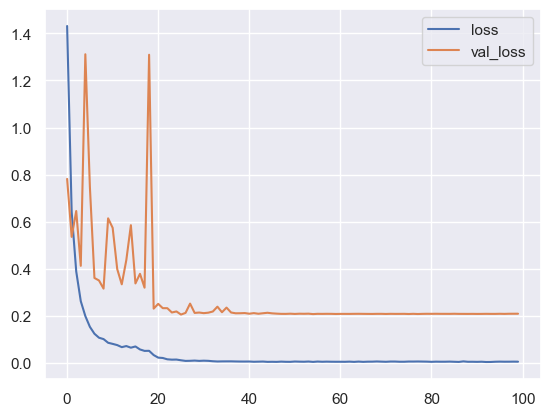

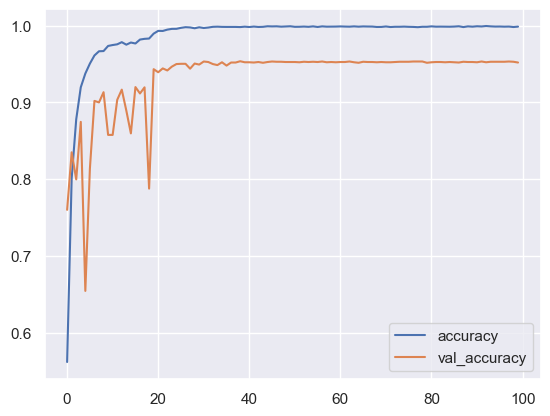

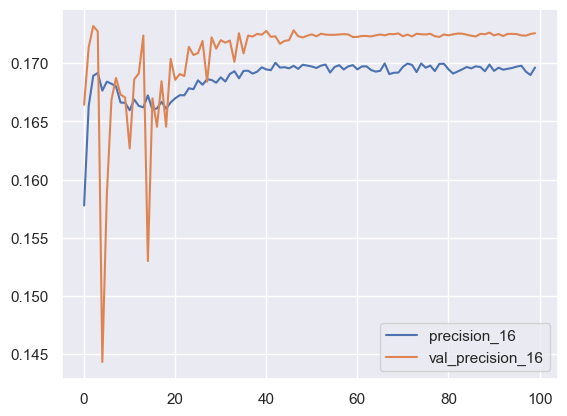

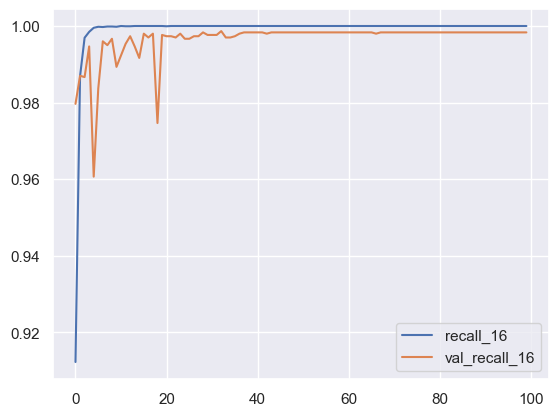

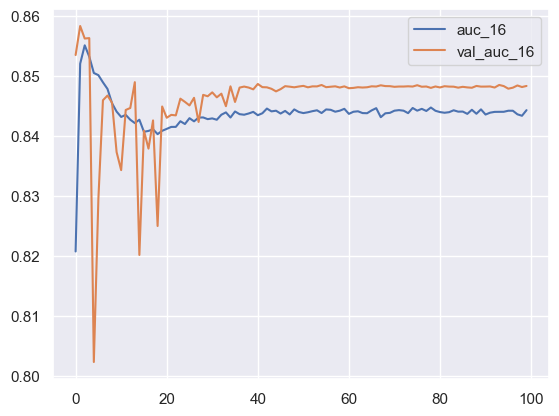

In [72]:
for i in range(5):
    history31v2_df.iloc[:,[i,i+5]].plot()

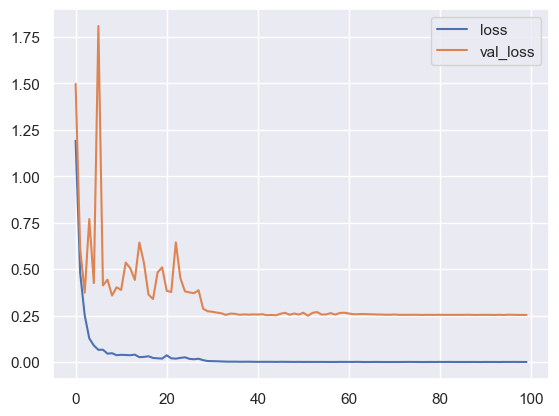

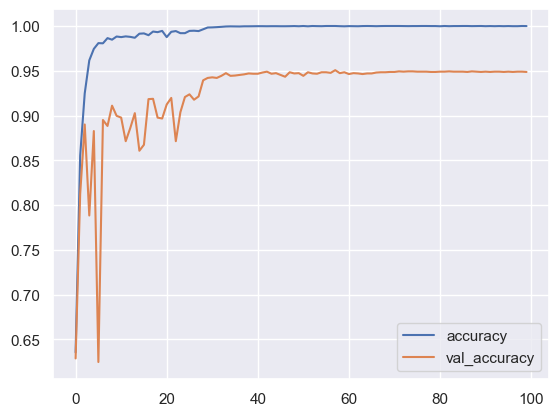

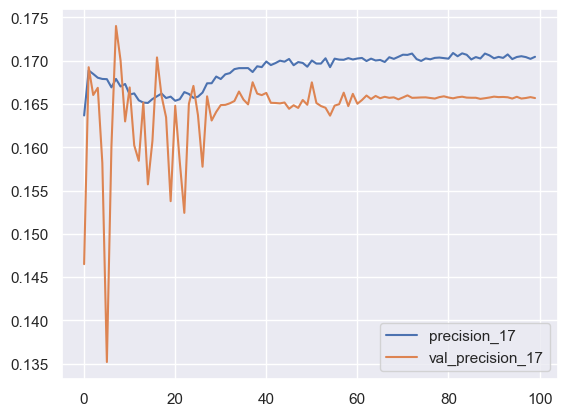

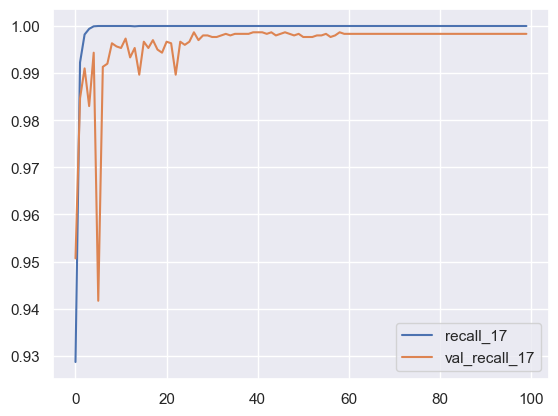

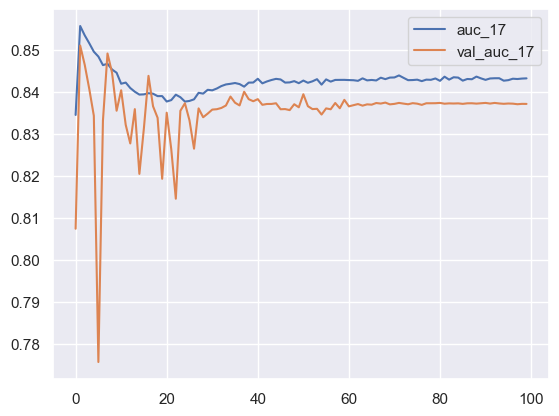

In [73]:
for i in range(5):
    history31_cc_df.iloc[:,[i,i+5]].plot()

## Model Testing

### Model31

In [32]:
test_results31 = get_results(
    lambda: get_model(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    test31_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_last-{model_format}.h5'
    )

test_results31

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 31, 256)       2560      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 15, 15, 256)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 15, 15, 256)       590080    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 7, 7, 256)        

,loss,acc,precision,recall,auc
best,0.528454,0.896000,0.186251,0.990667,0.852143
last,0.589442,0.902333,0.189729,0.991333,0.853805


### Model31V2

In [74]:
test_results31v2 = get_results(
    lambda: get_modelv2(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    test31_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_last-{model_format}.h5'
    )

test_results31v2

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 31, 31, 64)        640       
                                                                 
 batch_normalization_82 (Bat  (None, 31, 31, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 dropout_82 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_66 (Conv2D)          (None, 15, 15, 128)       73856     
                                                                 
 batch_normalization_83 (Bat  (None, 15, 15, 128)    

,loss,acc,precision,recall,auc
best,0.187919,0.951333,0.171365,0.999000,0.847420
last,0.186721,0.953333,0.172670,0.998667,0.848851


### Model31_CC

In [75]:
test_results31_cc = get_results(
    lambda: get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    test31_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_last-{model_format}.h5'
    )

test_results31_cc

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 31, 31, 64)        640       
                                                                 
 batch_normalization_90 (Bat  (None, 31, 31, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_90 (Dropout)        (None, 31, 31, 64)        0         
                                                                 
 conv2d_72 (Conv2D)          (None, 31, 31, 128)       73856     
                                                                 
 batch_normalization_91 (Bat  (None, 31, 31, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 15, 15, 128)    

,loss,acc,precision,recall,auc
best,0.223919,0.951,0.166778,0.999333,0.838220
last,0.223295,0.953,0.166945,0.999000,0.838488


In [78]:
test_results31_aug_cc = get_results(
    lambda: get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    make_dataset(f'test-aug-128/{class_size}/', img_size, batch_size),
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_last-{model_format}.h5',
    )

test_results31_aug_cc

Found 15000 files belonging to 15 classes.
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 31, 31, 64)        640       
                                                                 
 batch_normalization_110 (Ba  (None, 31, 31, 64)       256       
 tchNormalization)                                               
                                                                 
 dropout_110 (Dropout)       (None, 31, 31, 64)        0         
                                                                 
 conv2d_88 (Conv2D)          (None, 31, 31, 128)       73856     
                                                                 
 batch_normalization_111 (Ba  (None, 31, 31, 128)      512       
 tchNormalization)                                               
                                                                 
 max_pooli

,loss,acc,precision,recall,auc
best,0.264409,0.944,0.162673,0.998000,0.833577
last,0.269959,0.947,0.162932,0.998667,0.833658


### Result Compilation

In [89]:
with os.scandir(f'./model_checkpoints/1000/img{img_size}') as dir:
    checkpoint_dict = {}
    flag = 0
    for entry in dir:
        checkpoint = entry.name[:-3].split('-')
        model_name, cp_conv_nodes, cp_dense_nodes, cp_dropout, cp_batch_size, cp_epochs = checkpoint
        model_name = model_name[:-5]
        if model_name=='model31' or model_name == 'model31noaug':
            model = lambda:get_model(int(cp_conv_nodes), int(cp_dense_nodes), kernel, stride, img_size, 'relu', float(cp_dropout), lr, summary=False)
        elif model_name=='model31v2'or model_name == 'model31v2noaug':
            model = lambda:get_modelv2(int(cp_conv_nodes), int(cp_dense_nodes), kernel, stride, img_size, 'relu', float(cp_dropout), lr, summary=False)
        elif model_name=='model31_cc' or model_name == 'model31_cc_noaug':
            model = lambda:get_model_cc(int(cp_conv_nodes), int(cp_dense_nodes), kernel, stride, img_size, 'relu', float(cp_dropout), lr, summary=False)
        else:
            continue

        print(checkpoint)
        if not flag:
            flag = 1
            compiled_results31 = get_results(model, test31_ds, f'./model_checkpoints/{class_size}/img{img_size}/{entry.name}', checkpoint=entry.name)
        else:
            compiled_results31 = pd.concat((compiled_results31, get_results(model, test31_ds, f'./model_checkpoints/{class_size}/img{img_size}/{entry.name}', checkpoint=entry.name)))
        
compiled_results31 = compiled_results31.sort_values(by=['acc'], ascending=False)
display(compiled_results31)

['model31noaug_best', '256', '256', '0.2', '32', '100']
94/94 [==============================] - 2s 10ms/step - loss: 0.3728 - accuracy: 0.9027 - precision_150: 0.1607 - recall_150: 0.9927 - auc_150: 0.8250
['model31noaug_last', '256', '256', '0.2', '32', '100']
94/94 [==============================] - 1s 7ms/step - loss: 0.3753 - accuracy: 0.9133 - precision_151: 0.1616 - recall_151: 0.9947 - auc_151: 0.8256
['model31v2noaug_best', '256', '256', '0.3', '32', '100']
94/94 [==============================] - 1s 8ms/step - loss: 0.1328 - accuracy: 0.9600 - precision_152: 0.1758 - recall_152: 1.0000 - auc_152: 0.8536
['model31v2noaug_last', '256', '256', '0.3', '32', '100']
94/94 [==============================] - 1s 8ms/step - loss: 0.1358 - accuracy: 0.9617 - precision_153: 0.1771 - recall_153: 0.9997 - auc_153: 0.8542
['model31v2_best', '256', '256', '0.2', '32', '100']
94/94 [==============================] - 1s 8ms/step - loss: 0.1879 - accuracy: 0.9513 - precision_154: 0.1714 - recal

,loss,acc,precision,recall,auc
model31v2noaug_last-256-256-0.3-32-100.h5,0.135821,0.961667,0.177078,0.999667,0.854178
model31v2noaug_best-256-256-0.3-32-100.h5,0.132814,0.960000,0.175768,1.000000,0.853632
model31_cc_noaug_last-256-256-0.3-32-100.h5,0.150694,0.958667,0.173636,0.999333,0.849496
model31_cc_noaug_best-256-256-0.3-32-100.h5,0.155612,0.958000,0.172636,0.999333,0.847938
model31_cc_last-256-256-0.3-32-100.h5,0.189230,0.956667,0.175193,1.000000,0.847678
model31v2_best-256-256-0.3-32-100.h5,0.166306,0.955000,0.180689,0.999333,0.855333
model31v2_last-256-256-0.2-32-100.h5,0.186721,0.953333,0.172670,0.998667,0.848850
model31v2_last-256-256-0.3-32-100.h5,0.177651,0.953000,0.180461,0.999333,0.854715
model31_cc_last-256-256-0.2-32-100.h5,0.223295,0.953000,0.166945,0.999000,0.838488
model31_cc_best-256-256-0.3-32-100.h5,0.174010,0.952667,0.173981,0.999000,0.849494


In [65]:
top2 = compiled_results31[:2]
display(top2)
if not os.path.exists('./model_checkpoints/best_checkpoints/'):
    os.mkdir('./model_checkpoints/best_checkpoints/')

for top_model_fp in top2.index.to_list():
    shutil.copy2(f'./model_checkpoints/1000/img{img_size}/{top_model_fp}', f'./model_checkpoints/best_checkpoints/{top_model_fp}')

,loss,acc,precision,recall,auc
model31v2noaug_last-256-256-0.3-32-100.h5,0.135821,0.961667,0.177078,0.999667,0.854178
model31v2noaug_best-256-256-0.3-32-100.h5,0.132814,0.960000,0.175768,1.000000,0.853632


## Hyperparamter Tuning


In [24]:
X_train, y_train = [],[]
for x,y in train31_ds:
    X_train.extend(x.numpy().tolist())
    y_train.extend(y.numpy().tolist())

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)

(9028, 31, 31, 1) (9028, 15)


In [41]:
params = {
    'activation': ['relu','leaky_relu','tanh'],
    'kernel': [3],
    'stride':[1],
    'lr':[1e-3,1e-4,1e-5],
    'img_size':[img_size],
    'conv_nodes':[256],
    'dense_nodes':[256],
    'dropout':np.arange(0.2,0.41,0.02),
    'summary':[False]
}

make_df = lambda cv, entry: pd.concat((pd.DataFrame({'best':[cv.best_score_]}, index=[model_name]), pd.DataFrame([cv.best_params_], index=[model_name])), axis=1)
hpt_df = None
with os.scandir(f'./model_checkpoints/best_checkpoints') as dir:
    flag = 0
    for entry in dir:
        checkpoint = entry.name[:-3].split('-')
        model, cp_conv_nodes, cp_dense_nodes, cp_dropout, cp_batch_size, cp_epochs = checkpoint
        model_name = model[:-5]
        if model_name=='model31':
            model = get_model
        elif model_name=='model31v2':
            model = get_modelv2
        elif model_name=='model31_cc':
            model = get_model_cc
        else:
            continue

        cv = RandomizedSearchCV(KerasClassifier(model), params, cv=4)
        cv.fit(X_train[:3000], y_train[:3000])

        print(f'\n\nModel:{entry}\nBest Acc: {cv.best_score_}, params: {cv.best_params_}')
        if hpt_df is None:
            hpt_df = make_df(cv, entry)
        else:
            hpt_df = pd.concat((hpt_df, make_df(cv,entry)))

display(hpt_df)

C:\Users\linco\AppData\Local\Temp\ipykernel_3880\3503767595.py:30: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cv = RandomizedSearchCV(KerasClassifier(model), params, cv=4)


94/94 [==============================] - 2s 11ms/step - loss: 3.3116 - accuracy: 0.1290 - precision_138: 0.0952 - recall_138: 0.5503 - auc_138: 0.6008


Model:<DirEntry 'model31v2_best-256-256-0.3-32-100.h5'>
Best Acc: 0.15433333441615105, params: {'summary': False, 'stride': 1, 'lr': 0.0001, 'kernel': 3, 'img_size': 31, 'dropout': 0.35999999999999993, 'dense_nodes': 256, 'conv_nodes': 256, 'activation': 'leaky_relu'}


C:\Users\linco\AppData\Local\Temp\ipykernel_3880\3503767595.py:30: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cv = RandomizedSearchCV(KerasClassifier(model), params, cv=4)


94/94 [==============================] - 3s 17ms/step - loss: 3.3314 - accuracy: 0.1177 - precision_179: 0.0853 - recall_179: 0.4737 - auc_179: 0.5695


Model:<DirEntry 'model31_cc_last-256-256-0.3-32-100.h5'>
Best Acc: 0.1406666673719883, params: {'summary': False, 'stride': 1, 'lr': 1e-05, 'kernel': 3, 'img_size': 31, 'dropout': 0.22, 'dense_nodes': 256, 'conv_nodes': 256, 'activation': 'leaky_relu'}


,best,summary,stride,lr,kernel,img_size,dropout,dense_nodes,conv_nodes,activation
<DirEntry 'model31v2_best-256-256-0.3-32-100.h5'>,0.154333,False,1,0.00010,3,31,0.36,256,256,leaky_relu
<DirEntry 'model31_cc_last-256-256-0.3-32-100.h5'>,0.140667,False,1,0.00001,3,31,0.22,256,256,leaky_relu


In [48]:
#Hyperparameter-tuned model
with tf.device('/GPU:0'):   
    model31v2 = get_modelv2(256, 256, 3, 1, 31, 'leaky_relu', 0.36, 0.00010)
    visualkeras.layered_view(model31v2).show()
    model31v2_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_HPT_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history31v2 = model31v2.fit(train_aug31_ds ,validation_data=validation31_ds, epochs=epochs, shuffle=True, callbacks=[model31v2_checkpoint,reducelr])
    model31v2.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_HPT_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_182"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_633 (Conv2D)         (None, 31, 31, 64)        640       
                                                                 
 batch_normalization_798 (Ba  (None, 31, 31, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_453 (MaxPooli  (None, 15, 15, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_814 (Dropout)       (None, 15, 15, 64)        0         
                                                                 
 conv2d_634 (Conv2D)         (None, 15, 15, 128)       73856     
                                                                 
 batch_normalization_799 (Ba  (None, 15, 15, 128)   

In [49]:
test_results31v2_HPT = get_results(
    lambda: get_modelv2(256, 256, 3, 1, 31, 'tanh', 0.42, 0.0001),
    test31_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_HPT_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_HPT_last-{model_format}.h5'
    )

test_results31v2_HPT

Model: "sequential_183"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_636 (Conv2D)         (None, 31, 31, 64)        640       
                                                                 
 batch_normalization_802 (Ba  (None, 31, 31, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_456 (MaxPooli  (None, 15, 15, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_818 (Dropout)       (None, 15, 15, 64)        0         
                                                                 
 conv2d_637 (Conv2D)         (None, 15, 15, 128)       73856     
                                                                 
 batch_normalization_803 (Ba  (None, 15, 15, 128)   

,loss,acc,precision,recall,auc
best,4.369475,0.066667,0.075363,0.560000,0.512401
last,4.379423,0.066667,0.069661,0.557333,0.510250


# Img_size 128

## Dataset

### Dataset Hyperparameter

In [14]:
#Hyper Parameters for Dataset
img_size= 128
batch_size = 64
class_size = 1000


In [15]:
train128_ds = make_dataset('train/', img_size, batch_size)
test128_ds = make_dataset('test/', img_size, batch_size)
validation128_ds = make_dataset('validation/', img_size, batch_size)

for img, labels in train128_ds:
    display(img, labels)
    break

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


<tf.Tensor: shape=(64, 128, 128, 1), dtype=float32, numpy=
array([[[[117.421875],
         [ 86.1875  ],
         [ 37.078125],
         ...,
         [102.515625],
         [ 91.90625 ],
         [114.46875 ]],

        [[121.40625 ],
         [ 92.125   ],
         [ 43.890625],
         ...,
         [ 77.125   ],
         [114.96875 ],
         [104.      ]],

        [[119.765625],
         [ 89.828125],
         [ 33.171875],
         ...,
         [ 91.453125],
         [ 73.40625 ],
         [106.625   ]],

        ...,

        [[119.734375],
         [144.89062 ],
         [152.10938 ],
         ...,
         [182.8125  ],
         [129.65625 ],
         [122.671875]],

        [[107.484375],
         [129.90625 ],
         [129.46875 ],
         ...,
         [164.21875 ],
         [160.82812 ],
         [166.20312 ]],

        [[ 90.828125],
         [ 87.984375],
         [103.40625 ],
         ...,
         [173.85938 ],
         [160.51562 ],
         [166.79688 ]]],


 

<tf.Tensor: shape=(64, 15), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0

## Data Augmentation

### Augmenting dataset to equal class size

In [16]:
create_aug_dataset(class_size, train, f'./train-aug-{img_size}', img_size)
create_aug_dataset(class_size, test, f'./test-aug-{img_size}',  img_size)

Dataset found in device.
Dataset found in device.


In [17]:
train_aug128_ds = make_dataset(f'train-aug-{img_size}/{class_size}/', img_size, batch_size)

Found 15000 files belonging to 15 classes.


## Model Training

In [18]:
#Hyper parameters for model
conv_nodes = 256
dense_nodes = 256

lr = 1e-3
dropout = 0.4
kernel = 3
stride = 2
epochs = 100

model_format = f'{conv_nodes}-{dense_nodes}-{dropout}-{batch_size}-{epochs}'

In [19]:
if not os.path.exists(f'./model_checkpoints/{class_size}'):
    os.mkdir(f'./model_checkpoints/{class_size}')
if not os.path.exists(f'./model_checkpoints/{class_size}/img{img_size}'):
    os.mkdir(f'./model_checkpoints/{class_size}/img{img_size}')

In [20]:
optimizer = Adam(learning_rate=lr)
loss = CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy',Precision(), Recall(), AUC()]

In [21]:
#Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reducelr = ReduceLROnPlateau(monitor='val_loss',patience=5)

### Model128


In [77]:
with tf.device('/GPU:0'):   
    model128 = get_model(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    
    visualkeras.layered_view(model128).show()
    model_checkpoint128 = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history128 = model128.fit(train_aug128_ds ,validation_data=validation128_ds, epochs=epochs, shuffle=True, callbacks=[model_checkpoint128,reducelr, early_stopping])
    model128.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_469 (Conv2D)         (None, 64, 64, 256)       2560      
                                                                 
 max_pooling2d_395 (MaxPooli  (None, 32, 32, 256)      0         
 ng2D)                                                           
                                                                 
 dropout_613 (Dropout)       (None, 32, 32, 256)       0         
                                                                 
 conv2d_470 (Conv2D)         (None, 16, 16, 256)       590080    
                                                                 
 max_pooling2d_396 (MaxPooli  (None, 8, 8, 256)        0         
 ng2D)                                                           
                                                                 
 dropout_614 (Dropout)       (None, 8, 8, 256)      

In [78]:
history128_df = pd.DataFrame(history128.history)
history128_df


,loss,accuracy,precision_145,recall_145,auc_145,val_loss,val_accuracy,val_precision_145,val_recall_145,val_auc_145,lr
0,3.334916,0.070267,0.063544,0.026133,0.504264,2.705619,0.091000,0.000000,0.000000,0.528790,0.00100
1,2.628369,0.113733,0.112644,0.180133,0.589294,2.437287,0.235333,0.187035,0.284667,0.725709,0.00100
2,2.488900,0.171000,0.121673,0.444400,0.666727,2.274412,0.234000,0.157194,0.555000,0.760555,0.00100
3,2.365913,0.213000,0.126217,0.593800,0.703201,2.106489,0.316333,0.153009,0.703333,0.780670,0.00100
4,2.344645,0.233067,0.129087,0.594867,0.704945,2.006245,0.352000,0.157675,0.755000,0.800444,0.00100
...,...,...,...,...,...,...,...,...,...,...,...
58,0.739604,0.751667,0.112674,0.993133,0.734191,0.477196,0.850667,0.114573,0.996667,0.739127,0.00001
59,0.729989,0.753600,0.113247,0.994667,0.736135,0.481193,0.849000,0.114573,0.996667,0.739099,0.00001
60,0.715010,0.759133,0.113097,0.993933,0.735530,0.488521,0.849667,0.114700,0.996667,0.739326,0.00001
61,0.708346,0.762200,0.113194,0.993200,0.736137,0.495316,0.844667,0.114664,0.997000,0.739033,0.00001


### Model128V2

In [103]:
with tf.device('/GPU:0'):   
    model128v2 = get_modelv2(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    visualkeras.layered_view(model128).show()
    model_checkpoint128v2 = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history128v2 = model128v2.fit(train_aug128_ds ,validation_data=validation128_ds, epochs=epochs, shuffle=True, callbacks=[model_checkpoint128v2,reducelr, early_stopping])
    model128v2.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_178"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_567 (Conv2D)         (None, 64, 64, 64)        640       
                                                                 
 batch_normalization_400 (Ba  (None, 64, 64, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_471 (MaxPooli  (None, 32, 32, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_740 (Dropout)       (None, 32, 32, 64)        0         
                                                                 
 conv2d_568 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_401 (Ba  (None, 16, 16, 128)   

In [104]:
history128v2_df = pd.DataFrame(history128v2.history)
history128v2_df


,loss,accuracy,precision_175,recall_175,auc_175,val_loss,val_accuracy,val_precision_175,val_recall_175,val_auc_175,lr
0,2.489213,0.262600,0.126008,0.732533,0.716123,3.088239,0.179333,0.132537,0.665333,0.705615,0.00100
1,1.739342,0.446400,0.149132,0.888600,0.799716,1.184045,0.619000,0.157573,0.953000,0.833003,0.00100
2,1.414837,0.538600,0.154022,0.933867,0.820851,5.845792,0.216333,0.109442,0.677667,0.648228,0.00100
3,1.244870,0.591733,0.154582,0.954000,0.826835,0.885690,0.721667,0.161278,0.969333,0.835329,0.00100
4,1.117014,0.628867,0.155492,0.968133,0.831467,0.724552,0.767000,0.164190,0.983333,0.843654,0.00100
5,1.006864,0.668800,0.155880,0.975600,0.833066,1.035060,0.667667,0.148754,0.970667,0.814408,0.00100
6,0.916413,0.700267,0.155134,0.982600,0.832517,1.682802,0.525333,0.144314,0.929333,0.790631,0.00100
7,0.854417,0.716000,0.154988,0.985467,0.832017,0.666179,0.783667,0.167570,0.989667,0.847649,0.00100
8,0.801695,0.734333,0.155546,0.988600,0.833391,1.574124,0.577667,0.144855,0.939333,0.791049,0.00100
9,0.757898,0.749067,0.155593,0.989333,0.832584,5.522453,0.286333,0.118011,0.768333,0.688374,0.00100


### Model128_CC

In [25]:
with tf.device('/GPU:0'):   
    model128_cc = get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr)
    visualkeras.layered_view(model128_cc).show()
    model128_cc_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history128_cc = model128_cc.fit(train_aug128_ds ,validation_data=validation128_ds, epochs=epochs, shuffle=True, callbacks=[model128_cc_checkpoint,reducelr])
    model128_cc.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_last-{model_format}.h5', save_format='h5', overwrite=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 batch_normalization_5 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)     

In [26]:
history128_cc_df = pd.DataFrame(history128_cc.history)
history128_cc_df

,loss,accuracy,precision_2,recall_2,auc_2,val_loss,val_accuracy,val_precision_2,val_recall_2,val_auc_2,lr
0,2.523299,0.245733,0.125152,0.728067,0.714233,1.653698,0.479667,0.148421,0.907000,0.802424,0.00100
1,1.780188,0.420933,0.147782,0.892800,0.802108,1.146989,0.638000,0.158339,0.969667,0.836276,0.00100
2,1.464490,0.522067,0.152122,0.941867,0.819267,1.136325,0.621667,0.150257,0.975667,0.824203,0.00100
3,1.243085,0.590333,0.153299,0.963533,0.827091,1.453973,0.553667,0.161610,0.955333,0.829092,0.00100
4,1.100750,0.636467,0.153916,0.973867,0.830703,0.624769,0.812333,0.153505,0.992667,0.833685,0.00100
...,...,...,...,...,...,...,...,...,...,...,...
95,0.049900,0.983333,0.169702,1.000000,0.840652,0.113144,0.969333,0.187633,0.999333,0.860857,0.00010
96,0.043323,0.984800,0.169419,1.000000,0.840102,0.096283,0.976667,0.186733,0.999333,0.860238,0.00010
97,0.045933,0.984667,0.169136,1.000000,0.839993,0.107200,0.972667,0.188764,0.999000,0.861664,0.00010
98,0.047131,0.984333,0.169470,1.000000,0.840569,0.100845,0.973000,0.187598,0.999333,0.861181,0.00001


### Val_acc comparison

In [105]:
history128_df.iloc[[history128_df['val_accuracy'].argmax()]]

,loss,accuracy,precision_145,recall_145,auc_145,val_loss,val_accuracy,val_precision_145,val_recall_145,val_auc_145,lr
52,0.786741,0.740333,0.114628,0.9916,0.740722,0.456824,0.854667,0.116003,0.996,0.743651,0.0001


In [106]:
history128v2_df.iloc[[history128v2_df['val_accuracy'].argmax()]]

,loss,accuracy,precision_175,recall_175,auc_175,val_loss,val_accuracy,val_precision_175,val_recall_175,val_auc_175,lr
39,0.273666,0.909333,0.158932,0.999733,0.833093,0.160986,0.952667,0.16939,0.998667,0.845732,0.0001


In [27]:
history128_cc_df.iloc[[history128_cc_df['val_accuracy'].argmax()]]

,loss,accuracy,precision_2,recall_2,auc_2,val_loss,val_accuracy,val_precision_2,val_recall_2,val_auc_2,lr
87,0.05405,0.982067,0.168765,0.999933,0.839869,0.094328,0.977333,0.186826,0.999333,0.860037,0.0001


### plots

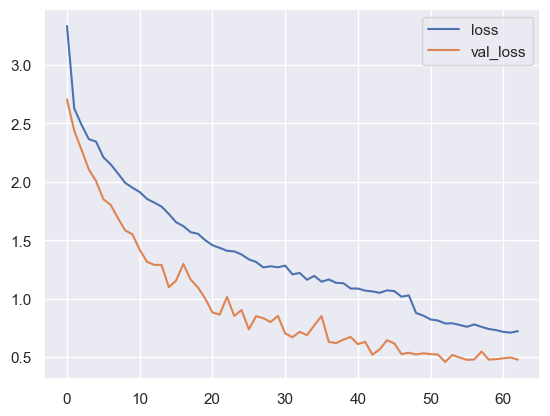

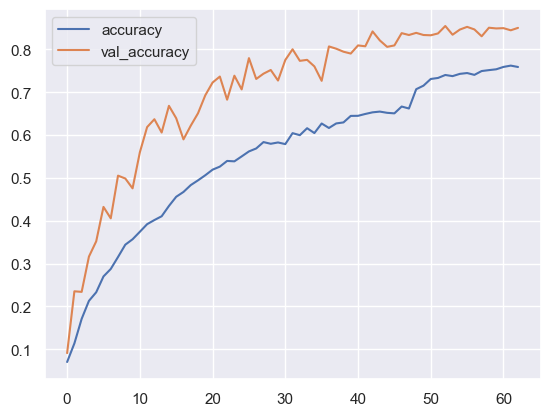

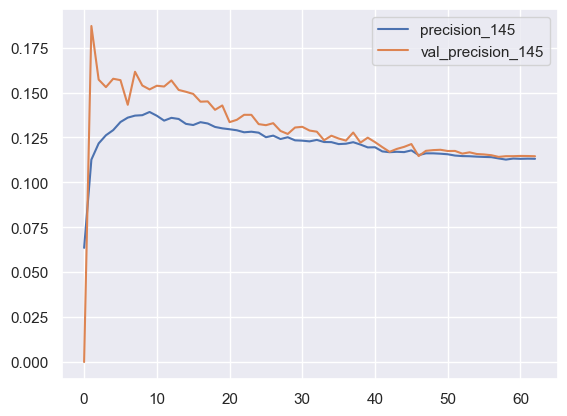

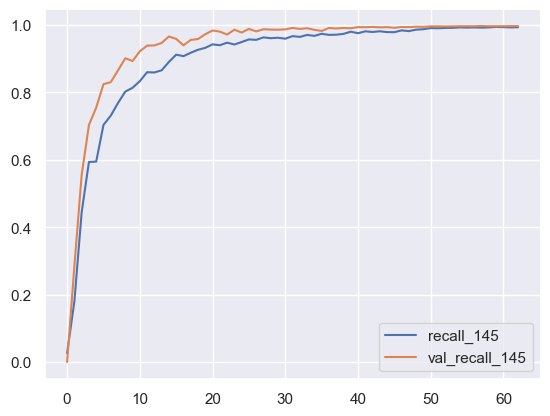

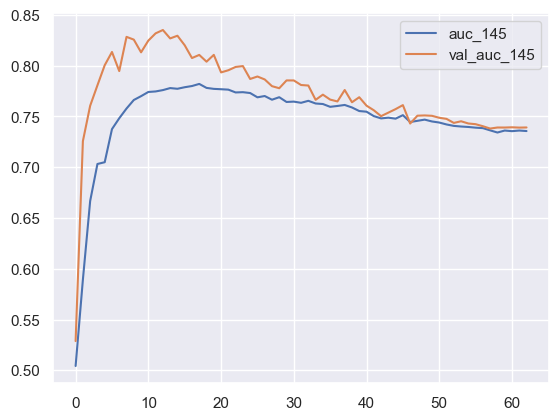

In [108]:
for i in range(5):
    history128_df.iloc[:,[i,i+5]].plot()

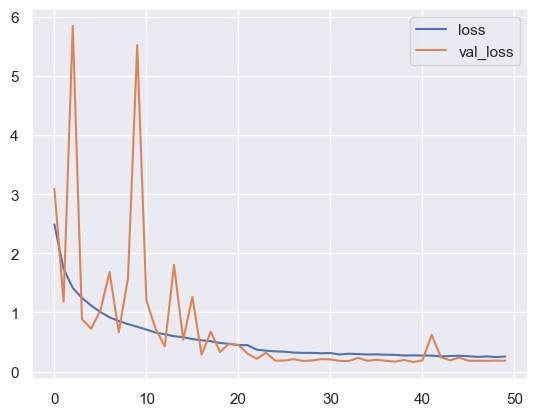

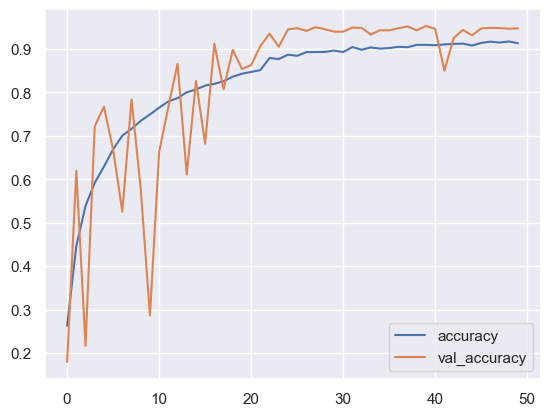

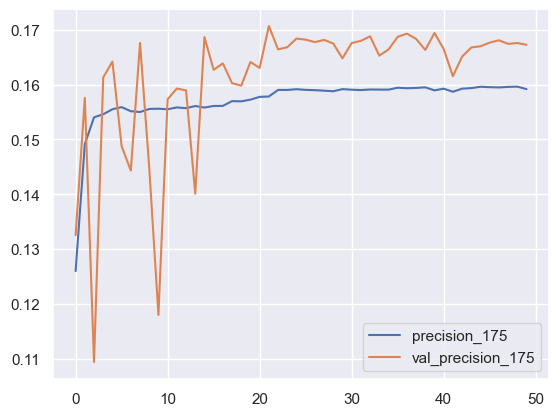

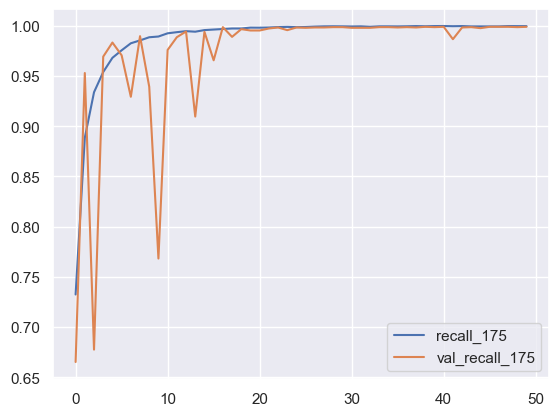

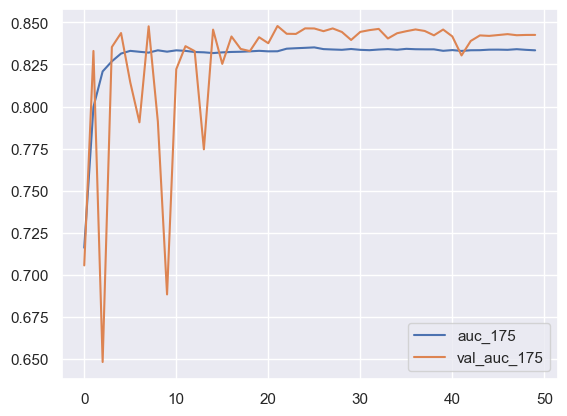

In [107]:
for i in range(5):
    history128v2_df.iloc[:,[i,i+5]].plot()

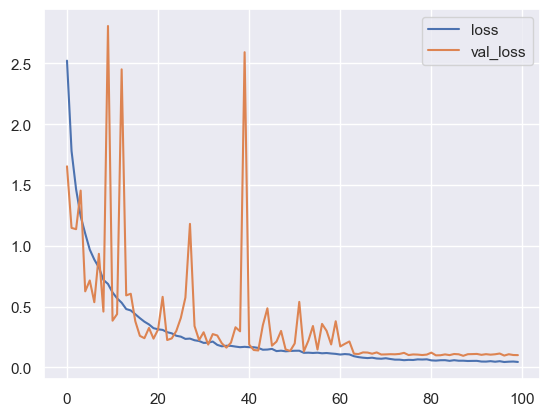

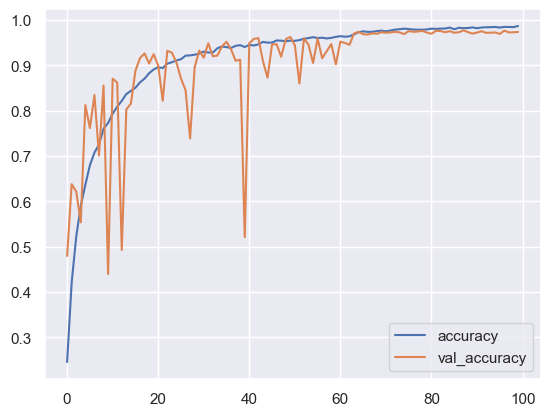

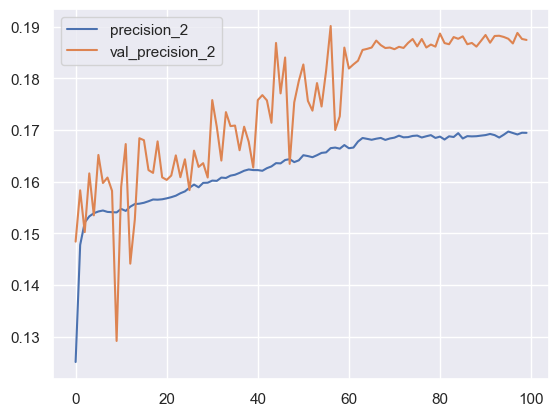

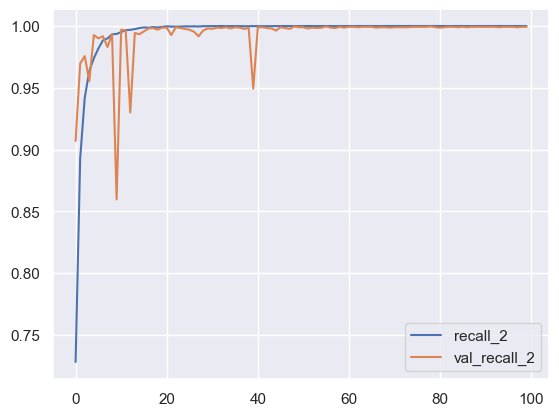

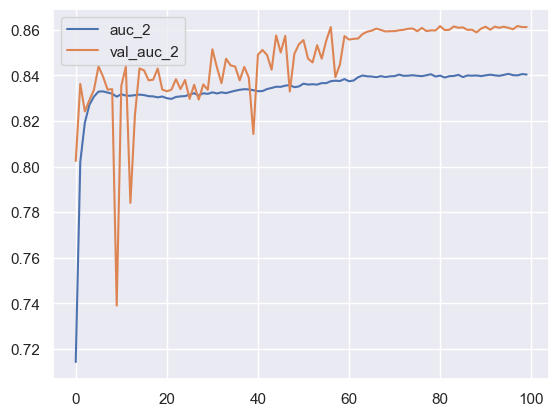

In [28]:
for i in range(5):
    history128_cc_df.iloc[:,[i,i+5]].plot()

## Model Testing

### Model128

In [ ]:
test_results128 = get_results(
    lambda: get_model(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    test128_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_last-{model_format}.h5'
    )

test_results128

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 64, 64, 256)       2560      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 32, 32, 256)      0         
 g2D)                                                            
                                                                 
 dropout_88 (Dropout)        (None, 32, 32, 256)       0         
                                                                 
 conv2d_82 (Conv2D)          (None, 16, 16, 256)       590080    
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 8, 8, 256)        0         
 g2D)                                                            
                                                                 
 dropout_89 (Dropout)        (None, 8, 8, 256)       

,loss,acc,precision,recall,auc
best,0.355054,0.901667,0.115048,0.994667,0.742123
last,0.353901,0.909000,0.113990,0.995667,0.737140


### Model128V2

In [ ]:
test_results128v2 = get_results(
    lambda: get_modelv2(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    test128_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_last-{model_format}.h5'
    )

test_results128v2

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_96 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_88 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_97 (Dropout)        (None, 8, 8, 128)       

,loss,acc,precision,recall,auc
best,0.347490,0.882000,0.137516,0.994333,0.795527
last,0.530429,0.836667,0.132444,0.989000,0.785400


### Model128_CC

In [29]:
test_results128_cc = get_results(
    lambda: get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    test128_ds,
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_last-{model_format}.h5'
    )

test_results128_cc

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 batch_normalization_10 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_11 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 128)     

,loss,acc,precision,recall,auc
best,0.098915,0.974667,0.185357,1.0,0.858861
last,0.101445,0.973667,0.186463,1.0,0.859678


In [30]:
test_results128_aug_cc = get_results(
    lambda: get_model_cc(conv_nodes, dense_nodes, kernel, stride, img_size, 'relu', dropout, lr),
    make_dataset(f'test-aug-128/{class_size}/', img_size, batch_size),
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_best-{model_format}.h5',
    f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}_cc_last-{model_format}.h5',
    )

test_results128_aug_cc

Found 15000 files belonging to 15 classes.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 batch_normalization_20 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_21 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 max_poolin

,loss,acc,precision,recall,auc
best,0.099034,0.974000,0.184843,1.0,0.858663
last,0.102707,0.974667,0.186254,1.0,0.859262


### Result Compilation

In [22]:
with os.scandir(f'./model_checkpoints/1000/img{img_size}') as dir:
    checkpoint_dict = {}
    flag = 0
    for entry in dir:
        checkpoint = entry.name[:-3].split('-')
        model_name, cp_conv_nodes, cp_dense_nodes, cp_dropout, cp_batch_size, cp_epochs = checkpoint
        model_name = model_name[:-5]
        if model_name=='model128':
            model = lambda:get_model(int(cp_conv_nodes), int(cp_dense_nodes), kernel, stride, img_size, 'relu', float(cp_dropout), lr, summary=False)
        elif model_name=='model128v2':
            model = lambda:get_modelv2(int(cp_conv_nodes), int(cp_dense_nodes), kernel, stride, img_size, 'relu', float(cp_dropout), lr, summary=False)
        elif model_name=='model128_cc':
            model = lambda:get_model_cc(int(cp_conv_nodes), int(cp_dense_nodes), kernel, stride, img_size, 'relu', float(cp_dropout), lr, summary=False)
        else:
            continue
        
        
        if not flag:
            flag = 1
            compiled_results = get_results(model, test128_ds, f'./model_checkpoints/{class_size}/img{img_size}/{entry.name}', checkpoint=entry.name)
        else:
            compiled_results = pd.concat((compiled_results, get_results(model, test128_ds, f'./model_checkpoints/{class_size}/img{img_size}/{entry.name}', checkpoint=entry.name)))
        
compiled_results = compiled_results.sort_values(by=['acc'], ascending=False)
display(compiled_results)

47/47 [==============================] - 1s 17ms/step - loss: 0.4512 - accuracy: 0.8540 - precision_6: 0.1148 - recall_6: 0.9983 - auc_6: 0.7400


,loss,acc,precision,recall,auc
model128_cc_best-256-256-0.4-64-100.h5,0.098915,0.974667,0.185357,1.000000,0.858861
model128_cc_last-256-256-0.4-64-100.h5,0.101445,0.973667,0.186463,1.000000,0.859678
model128v2_best-256-256-0.4-64-100.h5,0.146980,0.954333,0.168740,0.999000,0.846452
model128v2_last-256-256-0.4-64-100.h5,0.172315,0.945000,0.166917,0.999667,0.842704
model128_best-256-256-0.4-64-100.h5,0.429587,0.861333,0.116360,0.998333,0.745185
model128_last-256-256-0.4-64-100.h5,0.451231,0.854000,0.114808,0.998333,0.740003


In [60]:
top2 = compiled_results[:2]
display(top2)
if not os.path.exists('./model_checkpoints/best_checkpoints/'):
    os.mkdir('./model_checkpoints/best_checkpoints/')

for top_model_fp in top2.index.to_list():
    shutil.copy2(f'./model_checkpoints/1000/img{img_size}/{top_model_fp}', f'./model_checkpoints/best_checkpoints/{top_model_fp}')

,loss,acc,precision,recall,auc
model128_cc_best-256-256-0.4-64-100.h5,0.098915,0.974667,0.185357,1.0,0.858861
model128_cc_last-256-256-0.4-64-100.h5,0.101445,0.973667,0.186463,1.0,0.859678


## Hyperparameter Tuning

In [293]:
X_train, y_train = [],[]
for i, (x,y) in enumerate(train128_ds):
    X_train.extend(x.numpy().tolist())
    y_train.extend(y.numpy().tolist())
    if i == 100-1:
        break

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)

(6400, 128, 128, 1) (6400, 15)


In [ ]:
params = {
    'activation': ['relu','leaky_relu','tanh'],
    'kernel': [3],
    'stride':[2],
    'lr':[1e-3,1e-4,1e-5],
    'img_size':[img_size],
    'conv_nodes':[256],
    'dense_nodes':[256],
    'dropout':np.arange(0.4,0.51,0.02),
    'summary':[False]
}

make_df = lambda cv: pd.DataFrame({'best':[cv.best_score_], 'params':[cv.best_params_]})

cv = RandomizedSearchCV(KerasClassifier(get_model_cc), params, cv=4)
cv.fit(X_train[:3000], y_train[:3000])

print(f'\n\nBest Acc: {cv.best_score_}, params: {cv.best_params_}')

In [ ]:
#Hyperparameter-tuned model
with tf.device('/GPU:0'):   
    model128v2 = get_modelv2(256, 256, 3, 1, 31, 'tanh', 0.42, 0.0001)
    visualkeras.layered_view(model128v2).show()
    model128v2_checkpoint = ModelCheckpoint(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_HPT_best-{model_format}.h5', monitor='val_loss',save_best_only=True, save_weights_only=True, save_format='h5')
    history128v2 = model128v2.fit(train_aug128_ds ,validation_data=validation128_ds, epochs=epochs, shuffle=True, callbacks=[model128v2_checkpoint,reducelr])
    model128v2.save_weights(f'./model_checkpoints/{class_size}/img{img_size}/model{img_size}v2_HPT_last-{model_format}.h5', save_format='h5', overwrite=True)